In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\sflan\AppData\Local\Temp\ipykernel_25636\1859362025.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2020-01-01", end="2025-10-01", progress=False)



Data Download Complete!
Shape of Returns Matrix: (927, 16)

Last 5 Days of Returns:
Ticker          AAPL       AMD      AMZN       APH       CEG      EQIX  \
Date                                                                     
2025-09-24 -0.008367 -0.000124 -0.002268 -0.018268  0.007340 -0.016936   
2025-09-25  0.017912  0.002421 -0.009399 -0.006518 -0.038474 -0.008788   
2025-09-26 -0.005504 -0.011287  0.007444  0.002205  0.014995  0.009484   
2025-09-29 -0.004040  0.011845  0.010816 -0.013054  0.009031 -0.010967   
2025-09-30  0.000786  0.002661 -0.011772  0.022390 -0.015664  0.001943   

Ticker           ETN     GOOGL      META      MSFT        MU      NVDA  \
Date                                                                     
2025-09-24  0.009963 -0.018124  0.006939  0.001805 -0.028650 -0.008216   
2025-09-25 -0.020273 -0.005478 -0.015568 -0.006135 -0.030642  0.004060   
2025-09-26  0.002300  0.003047 -0.006914  0.008699  0.002802  0.002810   
2025-09-29  0.004285 -0.01

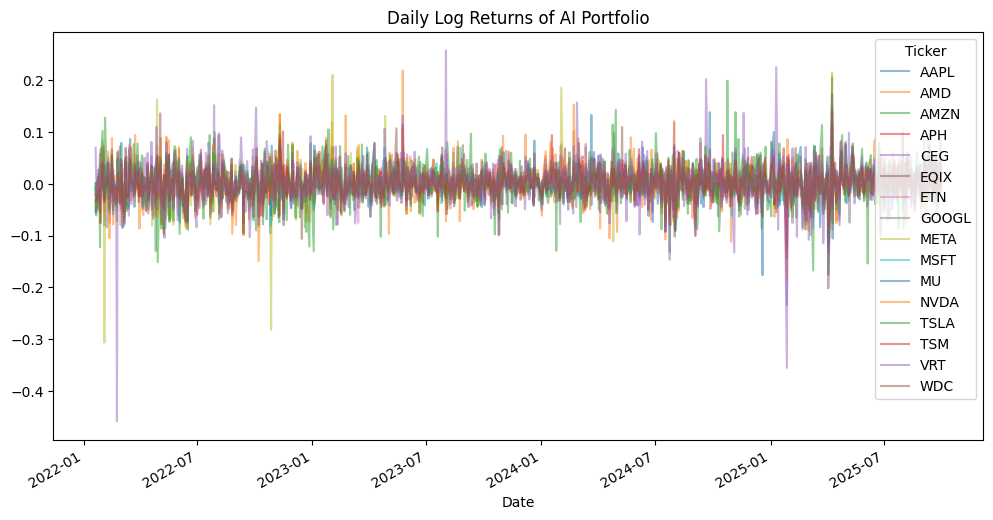

In [19]:
# 1. Defining the "AI Infrastructure" Portfolio
# Group them to stay organized, pass a flat list to yfinance
tickers = [
    # Semis (The Brains)
    "NVDA", "TSM", "AMD",
    # Memory (The Storage)
    "MU", "WDC",
    # Infrastructure/Cooling (The Body)
    "VRT", "APH", "EQIX",
    # Energy (The Power)
    "CEG", "ETN",
    # Mag 7 (The Consumers) - excluding NVDA since it's in Semis
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA"
]

# 2. Download Data (Last 5 Years)
print(f"Downloading data for {len(tickers)} tickers...")
data = yf.download(tickers, start="2020-01-01", end="2025-10-01", progress=False)
prices = data['Close']

# 4. Calculate Logarithmic Returns using NumPy
# Formula: ln(Price_t / Price_t-1)
# Log Returns are time-additive as opposed to simple returns, making them superior for the Monte Carlo simulations we will do later.
log_returns = np.log(prices / prices.shift(1))

# 5. Data Cleaning (Pandas)
# Drop the first row (NaN) created by the shift operation
log_returns = log_returns.dropna()

# 6. Checkpoint to make sure data and returns calculated correctly
print("\nData Download Complete!")
print(f"Shape of Returns Matrix: {log_returns.shape}")
print("\nLast 5 Days of Returns:")
print(log_returns.tail())
log_returns.plot(figsize=(12, 6), title="Daily Log Returns of AI Portfolio", alpha=0.5)
plt.show()

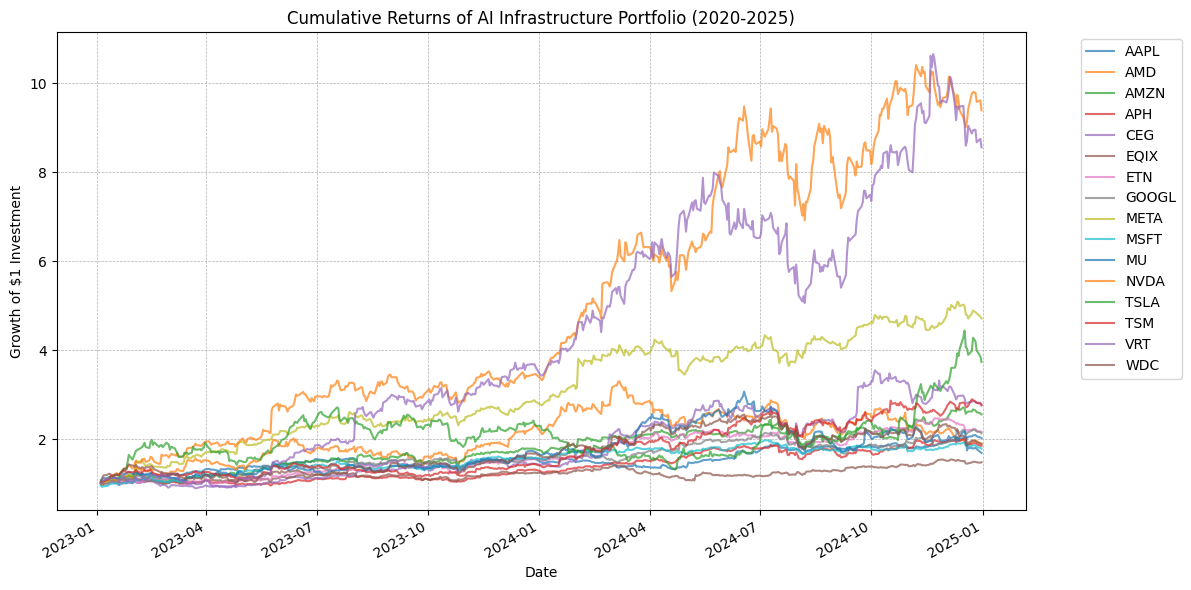

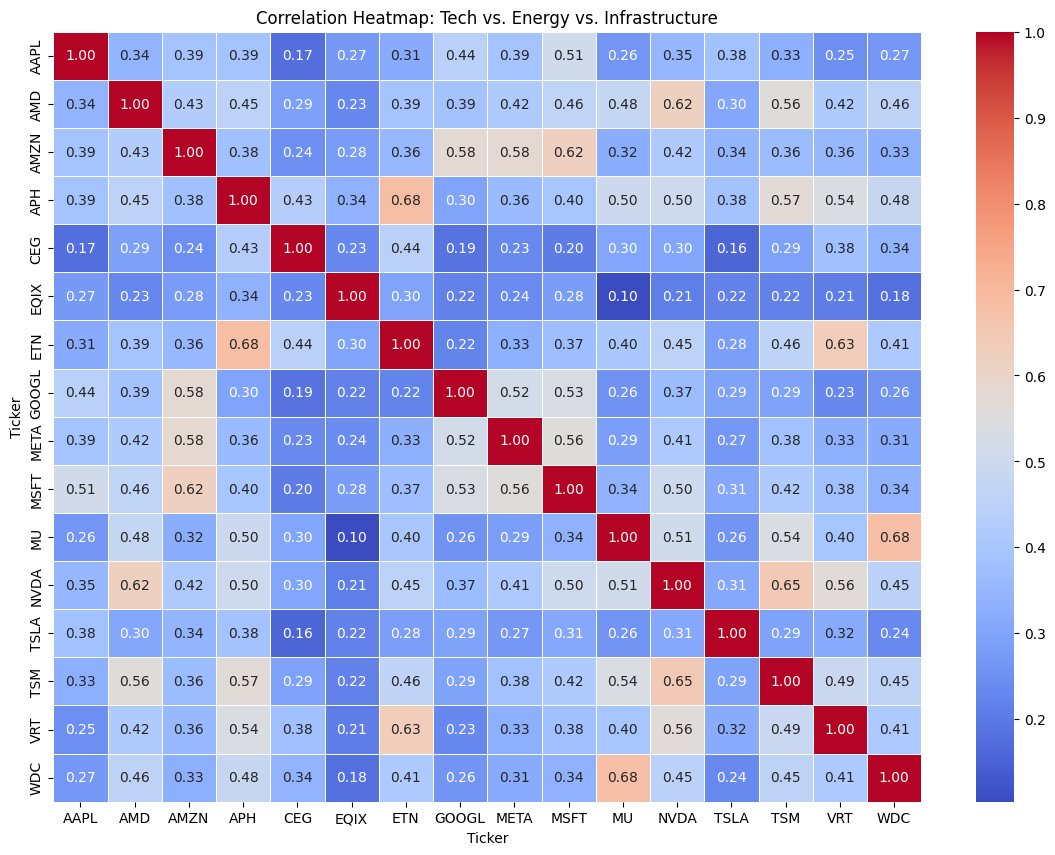


Annualized Covariance Matrix (First 5x5 view):
Ticker      AAPL       AMD      AMZN       APH       CEG
Ticker                                                  
AAPL    0.045346  0.034394  0.025330  0.018990  0.015279
AMD     0.034394  0.224363  0.061541  0.049207  0.055996
AMZN    0.025330  0.061541  0.093435  0.026625  0.030637
APH     0.018990  0.049207  0.026625  0.052936  0.040797
CEG     0.015279  0.055996  0.030637  0.040797  0.168114


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Visualizing Growth ---
# Calculating Cumulative Returns to see how the portfolio components have performed.
# Formula: Cumulative Return = exp(cumsum(log_returns))
cumulative_returns = log_returns.cumsum().apply(np.exp)

plt.figure(figsize=(12, 6))
cumulative_returns.plot(ax=plt.gca(), linewidth=1.5, alpha=0.7)
plt.title("Cumulative Returns of AI Infrastructure Portfolio (2020-2025)")
plt.ylabel("Growth of $1 Investment")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Moves legend outside
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# The Correlation Matrix
# This will be used to identify if 'Energy' stocks actually provide diversification from 'Tech'.
correlation_matrix = log_returns.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Tech vs. Energy vs. Infrastructure")
plt.show()

# The Covariance Matrix (The Monte Carlo Engine)
# It represents the volatility and risk.
# We multiply by 252 to "Annualize" the risk (252 trading days in a year accounting for weekends/holidays).
covariance_matrix = log_returns.cov() * 252

print("\nAnnualized Covariance Matrix (First 5x5 view):")
print(covariance_matrix.iloc[:5, :5])

Expected Annual Return: 23.70%
Annualized Volatility:  23.51%

--- RISK ANALYSIS (95% Confidence) ---
Initial Investment: $1,000,000.00
Mean Ending Value:  $1,264,268.83
Worst Case (5th %): $837,990.71
Value at Risk (VaR): $162,009.29
Interpretation: We are 95% confident that your loss over 1 year will NOT exceed this amount.


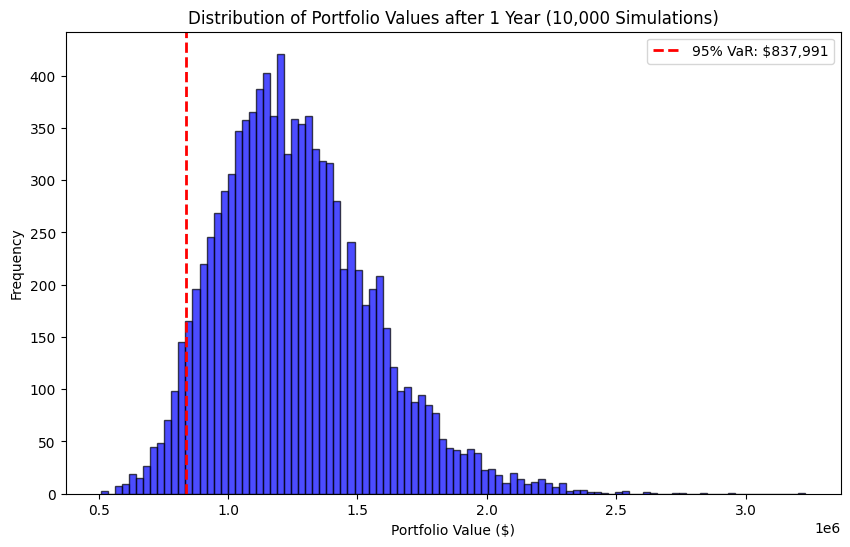

In [20]:
# Portfolio Construction
# Chose 16 tickers to begin with. Let's assume an equal weight portfolio for now.
# We can customize to add heavier weight to a specific stock later.
num_assets = len(tickers)
weights = np.array([1/num_assets] * num_assets)

# Portfolio Statistics
# Calculate expected portfolio return and volatility using Matrix Algebra.
# Volatility = sqrt(Weights.T(transposed) * Covariance (measured above) * Weights (equal for now)

# Annualize mean returns (252 days)
port_mean_return = np.sum(log_returns.mean() * weights) * 252

# Annualize Portfolio Volatility
port_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

print(f"Expected Annual Return: {port_mean_return:.2%}")
print(f"Annualized Volatility:  {port_volatility:.2%}")

# Monte Carlo Simulation Setup
T = 1.0           # Time horizon in years (1 year)
days = 252       # Trading days in a year
dt = T / days     # Time step
simulations = 10000 # Number of simulated instances

# Initial Investment
initial_portfolio_value = 1000000 

# Pre-allocate the simulation matrix (10,000 simulations x 252 days)
# We simulate the Portfolio value directly using the portfolio statistics calculated above.
portfolio_sims = np.zeros((days, simulations))
portfolio_sims[0] = initial_portfolio_value

# Loop through each day (vectorized across all 10,000 simulations)
for t in range(1, days):
    # Random Shock (Z score) from Normal Distribution
    Z = np.random.normal(0, 1, simulations)
    
    # Geometric Brownian Motion Formula:
    # New_Price = Old_Price * exp( (Mean - 0.5 * Vol^2)*dt + Vol * sqrt(dt) * Z )
    drift = (port_mean_return - 0.5 * port_volatility**2) * dt
    shock = port_volatility * np.sqrt(dt) * Z
    
    # Update current day's value based on previous day
    portfolio_sims[t] = portfolio_sims[t-1] * np.exp(drift + shock)

# Value at Risk (VaR) Analysis
# Get the final ending value for all 10,000 simulations
final_values = portfolio_sims[-1]

# Calculate the 95% VaR
# We look for the value at the 5th percentile (the worst 5% of outcomes)
var_95_percentile = np.percentile(final_values, 5)
var_95_amount = initial_portfolio_value - var_95_percentile

print("\n--- RISK ANALYSIS (95% Confidence) ---")
print(f"Initial Investment: ${initial_portfolio_value:,.2f}")
print(f"Mean Ending Value:  ${np.mean(final_values):,.2f}")
print(f"Worst Case (5th %): ${var_95_percentile:,.2f}")
print(f"Value at Risk (VaR): ${var_95_amount:,.2f}")
print("Interpretation: We are 95% confident that your loss over 1 year will NOT exceed this amount.")

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(var_95_percentile, color='red', linestyle='dashed', linewidth=2, label=f'95% VaR: ${var_95_percentile:,.0f}')
plt.title("Distribution of Portfolio Values after 1 Year (10,000 Simulations)")
plt.xlabel("Portfolio Value ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Simulating risk landscape...


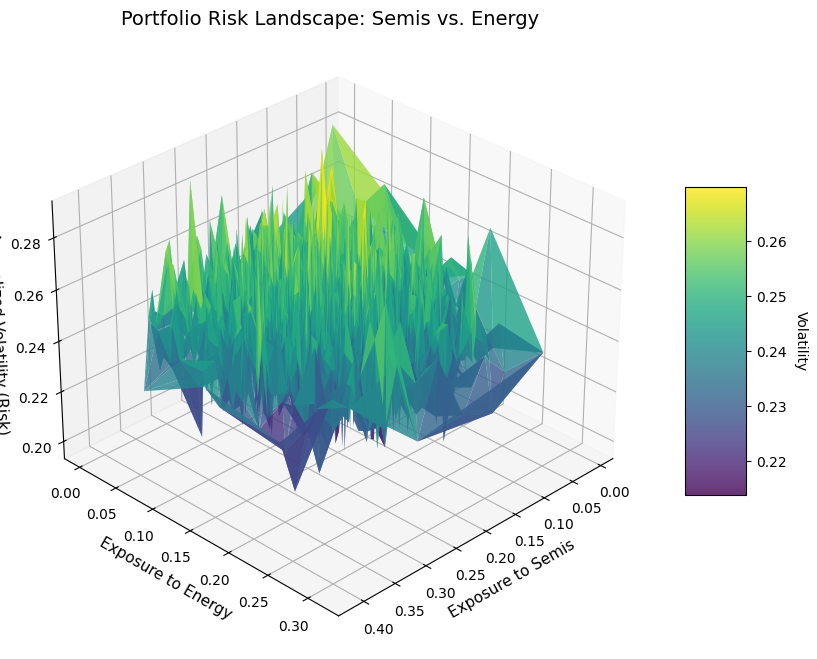

In [21]:
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Define Sectors for Analysis ---
# We want to see how these two specific sectors drive volatility
sector_map = {
    'SemiCon': ['NVDA', 'TSM', 'AMD'],
    'Energy': ['CEG', 'ETN']
}

# Helper to get indices for these sectors
semicon_indices = [tickers.index(t) for t in sector_map['SemiCon']]
energy_indices = [tickers.index(t) for t in sector_map['Energy']]

# --- 2. Run a Targeted Simulation (5,000 Portfolios) ---
n_points = 5000
results_semicon_weight = []
results_energy_weight = []
results_volatility = []

print("Simulating risk landscape...")

for _ in range(n_points):
    # Generate random weights
    w = np.random.random(len(tickers))
    w /= np.sum(w) # Normalize to sum to 1
    
    # Calculate Portfolio Volatility for this random mix
    # Vol = sqrt(w.T @ Sigma @ w)
    vol = np.sqrt(np.dot(w.T, np.dot(covariance_matrix, w)))
    
    # Store the specific sector weights and the resulting vol
    results_semicon_weight.append(np.sum(w[semicon_indices]))
    results_energy_weight.append(np.sum(w[energy_indices]))
    results_volatility.append(vol)

# --- 3. Plotting the 3D Surface ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
# X = SemiCon Exposure, Y = Energy Exposure, Z = Risk (Volatility)
surf = ax.plot_trisurf(results_semicon_weight, 
                       results_energy_weight, 
                       results_volatility, 
                       cmap='viridis', 
                       edgecolor='none', 
                       alpha=0.8)

# Labels
ax.set_title('Portfolio Risk Landscape: Semis vs. Energy', fontsize=14)
ax.set_xlabel('Exposure to Semis', fontsize=11)
ax.set_ylabel('Exposure to Energy', fontsize=11)
ax.set_zlabel('Annualized Volatility (Risk)', fontsize=11)

# Add a color bar to show the Volatility levels
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Volatility', rotation=270, labelpad=15)

# View Angle (Adjust these to rotate the plot!)
ax.view_init(elev=30, azim=45)

plt.show()